# ZTF24aahgqwk in NGC 3443

## Light Curve Notebook

This notebook begins with the 36 stacked images produced by our [Calibration Notebook](https://brianhill.github.io/supernova-observation/analyses/ZTF24aahgqwk/ZTF24aahgqwk-calibration.pdf), and produces a light curve, consisting of 18 Sloan r' and 18 Sloan g' data points.

See [a least squares notebook](https://brianhill.github.io/supernova-observation/analyses/ZTF24aahgqwk/related_analyses/least_squares.pdf) for
background for the method used below.

In [1]:
import os
import numpy as np
from scipy.optimize import least_squares
from astropy import units as u
from astropy.nddata import CCDData
from astropy.io import fits
from ccdproc import ImageFileCollection
import astroalign as aa
import matplotlib.pyplot as plt
%matplotlib inline
from math import log10, floor, sqrt, log, exp, pi

# THIS COMMENT IS THE LONGEST A LINE CAN BE AND STILL RENDER COMPLETELY WHEN PRINTING IN LANDSCAPE MODE.
# THIS COMMENT IS 72 CHARACTERS WITHOUT COUNTING THE NEWLINE AT THE END.

# This notebook needs to be able to find the stacked images.

home_directory = os.path.expanduser('~')
supernova_project_directory = os.path.join(home_directory, 'Projects', 'supernova-observation')
stacked_directory = os.path.join(supernova_project_directory, 'analyses', 'ZTF24aahgqwk', 'stacked')

# The 36 images are in the stacked directory. There were 18 observation sessions with 2 filters each.

# filters

filters = ['r', 'g']
filter_full_names = ["Sloan r'", "Sloan g'"]

# observation dates (UTC)

observation_dates = [
    '2024-03-20',
    '2024-03-21',
    '2024-03-23',
    '2024-03-27',
    '2024-04-02',
    '2024-04-03',
    '2024-04-04',
    '2024-04-06',
    '2024-04-10',
    '2024-04-11',
    '2024-04-13',
    '2024-04-17',
    '2024-04-21',
    '2024-04-22',
    '2024-04-23',
    '2024-04-29',
    '2024-04-30',
    '2024-05-02'
]

# We will need to specify rectangles surrounding the target and the reference stars.

# use named tuples to improve readability

from collections import namedtuple

Point = namedtuple('Point', 'x y')
Extent = namedtuple('Extent', 'width height')
Rectangle = namedtuple('Rectangle', 'center extent')

# Various utilities

def file_for_date_and_filter(date, filter):
    return os.path.join(stacked_directory, date + '-' + filter + '_stacked.fit')

def stacked_image_for_date_and_filter(date, filter):
    file = file_for_date_and_filter(date, filter)
    return CCDData.read(file, unit=u.adu)

# Log stretch utility

def log_stretch_transform(black_point, saturation_range):
    
    log_saturation_range = log10(saturation_range)
    
    def fn(pixel_value):
        pixel_value -= black_point
        if pixel_value <= 1.0:
            return 0
        else:
            log_pixel_value = log10(pixel_value)
            if log_pixel_value >= log_saturation_range:
                return 255;
            else:
                return floor(256 * log_pixel_value / log_saturation_range)
        
    return fn


## Specify the Regions of Interest for the Target and Reference Stars

In [2]:
# Guarantee the extent widths and heights are odd so the loops do not have to handle even and odd cases.
EXTENT_HALF_WIDTH = 10
EXTENT_WIDTH = 2 * EXTENT_HALF_WIDTH + 1
EXTENT_HEIGHT = EXTENT_WIDTH
EXTENT = Extent(EXTENT_WIDTH, EXTENT_HEIGHT)

CENTERS = [
    Point(708, 443), # target
    Point(177, 109), # reference star at far upper left
    Point(112, 368), # reference star at far left
    Point(585, 426), # reference star just left of center
    Point(982, 591), # reference star right of center
    Point(1271, 280), # reference star at far right
]

CENTER_COUNT = len(CENTERS)


## Display a Representative Image


Set OBSGEO-Y to -4483194.922 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851220.317 from OBSGEO-[LBH]'. [astropy.wcs.wcs]


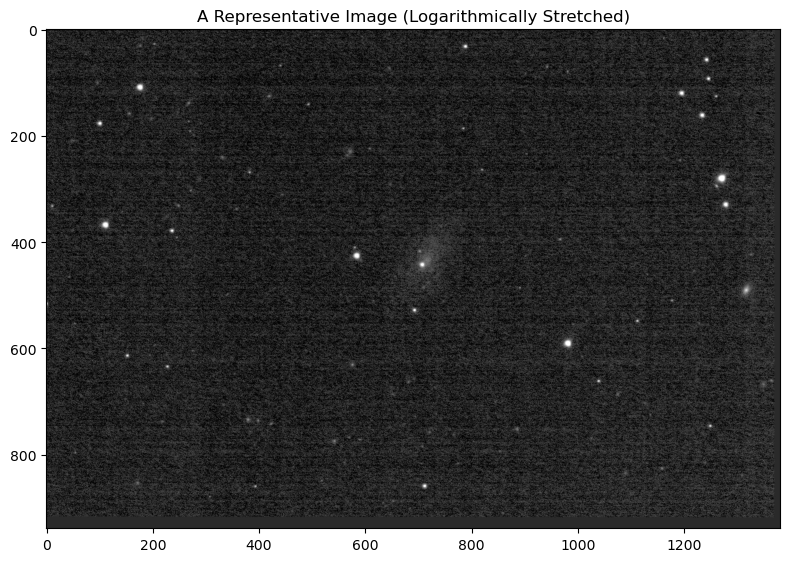

In [3]:
first_image = stacked_image_for_date_and_filter('2024-04-03', 'r')

# Log stretch

stretch_function = log_stretch_transform(8, 50)
stretch_transform = np.vectorize(stretch_function)

stretched_image = stretch_transform(first_image.data)

# Display the image

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

axes.imshow(stretched_image, cmap='gray')
axes.set_title("A Representative Image (Logarithmically Stretched)")

plt.tight_layout()
plt.show()


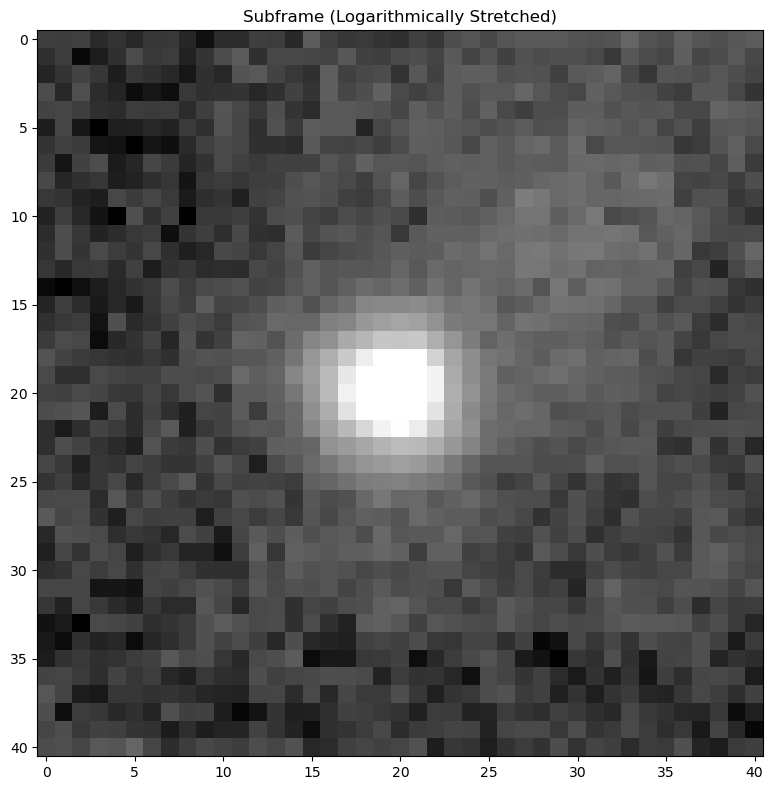

In [4]:
DISPLAY_WHICH_CENTER = 0

display_extent_half = 20
display_extent_width = 2 * display_extent_half + 1
display_extent_height = display_extent_width
display_extent = Extent(display_extent_width, display_extent_height)

display_center = CENTERS[DISPLAY_WHICH_CENTER]
display_left = display_center.x - display_extent_half
display_right = display_left + display_extent_width
display_top = display_center.y - display_extent_half
display_bottom = display_top + display_extent_height

subframe = stretched_image[display_top:display_bottom, display_left:display_right]

# Display the representative subtracted dark

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

axes.imshow(subframe, cmap='gray')
axes.set_title("Subframe (Logarithmically Stretched)")

plt.tight_layout()
plt.show()


In [5]:
def sigma_squared_for_fwhm(fwhm):
    return fwhm**2 / (8 * log(2))

def make_gaussian_with_flux(fwhm, flux, center_x, center_y):
    sigma_squared = sigma_squared_for_fwhm(fwhm)
    flux_factor = flux / 2 / pi / sigma_squared
    def gaussian(x, y):
        delta_x = x - center_x
        delta_y = y - center_y
        return flux_factor * exp(-(delta_x**2 + delta_y**2) / 2 / sigma_squared)
    return gaussian

def model_data_for_parameters(extent, total_background, fwhm, flux, center_x, center_y):
    model_data = np.zeros([extent.height, extent.width])
    model_data.fill(total_background)
    gaussian = make_gaussian_with_flux(fwhm, flux, center_x, center_y)
    for j in range(EXTENT_HEIGHT):
        for i in range(EXTENT_WIDTH):
            model_data[j, i] += gaussian(i, j)
    return model_data
    
# IS THERE A WAY TO USE NP.VECTORIZE?

PINDEX_TARGET_BACKGROUND = 0  # NB: THE TARGET BACKGROUND IS IN ADDITION TO THE GENERAL_BACKGROUND
PINDEX_GENERAL_BACKGROUND = 1
PINDEX_FWHM = 2

POFFSETINDEX_FLUX = 0
POFFSETINDEX_CENTER_X = 1
POFFSETINDEX_CENTER_Y = 2

def roi_residuals(image_data, target_index, center, extent, parameter_vector):
    left = center.x - extent.width // 2
    right = left + extent.width
    top = center.y - extent.height // 2
    bottom = top + extent.height
    roi_data = image_data[top:bottom, left:right]
    target_background = parameter_vector[PINDEX_TARGET_BACKGROUND]
    general_background = parameter_vector[PINDEX_GENERAL_BACKGROUND]
    total_background = target_background + general_background if target_index==0 else general_background
    fwhm = parameter_vector[PINDEX_FWHM]
    base_index = 3 + 3 * target_index 
    flux = parameter_vector[base_index + POFFSETINDEX_FLUX]
    center_x = parameter_vector[base_index + POFFSETINDEX_CENTER_X]
    center_y = parameter_vector[base_index + POFFSETINDEX_CENTER_Y]
    model_data = model_data_for_parameters(extent, total_background, fwhm, flux, center_x, center_y)
    return roi_data - model_data

def make_residuals_function(image_data, centers, extent):
    def residuals_function(parameter_vector):
        all_roi_residuals = [
            roi_residuals(image_data, i, center, extent, parameter_vector)
            for i, center in enumerate(centers)
        ]
        return np.concatenate(all_roi_residuals).ravel()
    
    return residuals_function

initial_guess_for_general_background = 0.0
initial_guess_for_target_background = 0.0
initial_guess_for_fwhm = 5.0

initial_parameter_vector = [
    initial_guess_for_target_background,
    initial_guess_for_general_background,
    initial_guess_for_fwhm
]

for index in range(CENTER_COUNT):
    initial_parameter_vector.append(10.0)  # Initial guess for flux
    initial_parameter_vector.append(0.0)   # Initial guess for center_x
    initial_parameter_vector.append(0.0)   # Initial guess for center_y

residuals_function = make_residuals_function(first_image, CENTERS, EXTENT)

result = least_squares(residuals_function, np.array(initial_parameter_vector))

print(result.x)

[-21.92575717  40.55509016  -6.73436377 -55.8386582  -43.4705267
 -42.39277425  -1.5611086  -25.95582425 -25.57604502  -1.94759506
 -26.10131682 -26.18515495  -1.998349   -26.20092733 -26.0605259
  -2.25115461 -25.86553169 -26.00338116  -1.63370073 -26.26247461
 -26.42877671]
